In [1]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel, RemoteSensingModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ, GaussianBases #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from pyproj import Proj
from scipy.spatial import cKDTree
from netCDF4 import Dataset
from datetime import datetime, timedelta

class RealWind:
    def __init__(self, start_date="2019-10-01", num_days=9):
        """
        Precompute and store wind data in a pandas DataFrame for fast lookup.
        The table includes time, northing, easting, U (east wind), and V (north wind).
        """
        self.proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
        self.wind_table = []  # List to accumulate wind data

        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        layer_range = (56, 68)  # Height range for averaging wind speeds
        bounding_box = (149, -35, 157, -26)

        for day_offset in range(num_days):
            current_date = start_date + timedelta(days=day_offset)
            date_str = current_date.strftime('%Y%m%d')
            file_path = rf"C:\\Users\\Nur Izfarwiza\\Documents\\Dissertation\\Wind\\MERRA2_400.tavg3_3d_asm_Nv.{date_str}.nc4"

            try:
                dataset = Dataset(file_path, 'r')
                lats = dataset.variables['lat'][:]
                lons = dataset.variables['lon'][:]
                
                # Apply the bounding box filter
                lat_indices = np.where((lats >= bounding_box[1]) & (lats <= bounding_box[3]))[0]
                lon_indices = np.where((lons >= bounding_box[0]) & (lons <= bounding_box[2]))[0]

                lats = lats[lat_indices]
                lons = lons[lon_indices]

                # Load and filter wind data within the bounding box
                eastward_wind = dataset.variables['U'][:, :, lat_indices, :][:, :, :, lon_indices]
                northward_wind = dataset.variables['V'][:, :, lat_indices, :][:, :, :, lon_indices]

                # Average over the specified vertical layers
                layer_range_slice = slice(layer_range[0], layer_range[1])
                eastward_wind_avg = np.mean(eastward_wind[:, layer_range_slice, :, :], axis=1)
                northward_wind_avg = np.mean(northward_wind[:, layer_range_slice, :, :], axis=1)

                # Read and convert the time variable
                time_var = np.array(dataset.variables['time'][:], dtype=np.float64)
                base_time_str = dataset.variables['time'].units.split(" since ")[1]
                base_time = datetime.strptime(base_time_str, "%Y-%m-%d %H:%M:%S")

                for t_idx, t_val in enumerate(time_var):
                    if not np.isfinite(t_val):
                        continue  # Skip invalid time values
                    timestamp = base_time + timedelta(minutes=int(t_val))

                    # Vectorized coordinate transformation
                    lon_grid, lat_grid = np.meshgrid(lons, lats)
                    easting, northing = self.proj(lon_grid, lat_grid)

                    # Flatten arrays to create a table of points
                    easting = easting.flatten()
                    northing = northing.flatten()
                    u_wind = eastward_wind_avg[t_idx].flatten()
                    v_wind = northward_wind_avg[t_idx].flatten()

                    # Filter out invalid projections
                    valid_mask = np.isfinite(easting) & np.isfinite(northing) & np.isfinite(u_wind) & np.isfinite(v_wind)

                    # Append valid data to the wind table
                    self.wind_table.extend(
                        zip([timestamp] * np.sum(valid_mask),
                            northing[valid_mask],
                            easting[valid_mask],
                            u_wind[valid_mask],
                            v_wind[valid_mask])
                    )

                dataset.close()

            except FileNotFoundError:
                print(f"File for {date_str} not found.")
            except Exception as e:
                print(f"Error loading {date_str}: {e}")

        # Convert to pandas DataFrame for fast lookups
        self.wind_table = pd.DataFrame(self.wind_table, columns=["Timestamp", "Northing", "Easting", "East Wind", "North Wind"])

        # Clean data: Drop NaN or Inf values
        self.wind_table = self.wind_table.replace([np.inf, -np.inf], np.nan)
        self.wind_table = self.wind_table.dropna()

        # Sort by timestamp for faster temporal queries
        self.wind_table = self.wind_table.sort_values(by="Timestamp").reset_index(drop=True)

        # Build a spatial KD-Tree for efficient spatial querying
        self.wind_tree = cKDTree(self.wind_table[["Easting", "Northing"]].values)

        print(f"Wind data precomputed for {len(self.wind_table)} points across {num_days} days.")

    def getwind(self, coords):
        """
        Get the interpolated wind speed for particles at given positions and times.

        Parameters:
        - coords: A tensor of shape (num_particles, num_observations, 3)
                  where each entry is [time, easting, northing].

        Returns:
        - wind_data: A tensor of shape (num_particles, num_observations, 2)
                     where each entry is [east_wind_speed, north_wind_speed].
        """
        num_particles, num_observations, _ = coords.shape
        wind_data = np.full((num_particles, num_observations, 2), np.nan)  # Initialize with NaN

        # Convert timestamps to datetime for lookup
        timestamps = np.array([datetime(2019, 10, 1) + timedelta(seconds=int(t)) 
                               for t in coords[:, :, 0].flatten()])

        # Batch query spatial points using cKDTree
        spatial_points = coords[:, :, 1:3].reshape(-1, 2)  # Reshape to (num_points, 2)
        distances, indices = self.wind_tree.query(spatial_points, k=4)  # 4 nearest neighbors for interpolation

        for idx, (dist, idxs) in enumerate(zip(distances, indices)):
            easting, northing = spatial_points[idx]
            timestamp = timestamps[idx]

            # Get the closest wind data points
            neighbor_data = self.wind_table.iloc[idxs]

            # Interpolation weights based on inverse distance
            weights = 1 / (dist + 1e-6)  # Avoid division by zero
            weights /= np.sum(weights)  # Normalize weights

            # Spatial interpolation of east and north wind components
            east_wind = np.dot(weights, neighbor_data["East Wind"].values)
            north_wind = np.dot(weights, neighbor_data["North Wind"].values)

            # Time-based interpolation (if needed)
            time_diffs = np.abs((neighbor_data["Timestamp"] - timestamp).dt.total_seconds())
            time_weight = 1 / (time_diffs + 1e-6)
            time_weight /= np.sum(time_weight)

            # Weighted average considering both spatial and temporal proximity
            # Spatial interpolation of east and north wind components
            east_wind_interpolated = np.dot(weights, neighbor_data["East Wind"].values)
            north_wind_interpolated = np.dot(weights, neighbor_data["North Wind"].values)



            # Store the interpolated wind speed
            particle_idx = idx // num_observations
            observation_idx = idx % num_observations
            wind_data[particle_idx, observation_idx] = [east_wind_interpolated, north_wind_interpolated]

        return wind_data


In [4]:
# Instead of this:
# windmodel = WindSimple(1,1)
obsLocs = np.array([
    [0, 1440, 400000, 600000],
    [0, 1440, 410000, 610000]])
sensors = RemoteSensingModel(obsLocs=obsLocs, simulation_minutes=1440, dt=180)
# Use your RealWind model:
windmodel = RealWind(start_date="2019-10-01", num_days=2)



C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_49228\2608638778.py:48: RuntimeWarning: invalid value encountered in cast
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_49228\2608638778.py:48: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  time_var = np.array(dataset.variables['time'][:], dtype=np.float64)


Wind data precomputed for 3952 points across 2 days.


TypeError: RemoteSensingModel.__init__() missing 1 required positional argument: 'obsLocs'

In [3]:
import inspect
import os
file_path = inspect.getfile(RemoteSensingModel)
print("RemoteSensingModel is defined at:", os.path.abspath(file_path))

RemoteSensingModel is defined at: c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\sensors.py


In [20]:
from scipy.stats import norm
import numpy as np
from pyproj import Proj

def generate_synthetic_data_within_boundary(boundary, num_points=200, D=2):
    """
    Generates synthetic observation points (X) and values (Y) within the given boundary.
    
    Parameters:
    - boundary: list of [min, max] in [t, x, y]
    - num_points: number of points to simulate
    - D: diffusion coefficient for blob spread

    Returns:
    - X: array of shape (num_points, 4) --> [t, t+10, x, y]
    - Y: array of shape (num_points,)
    """
    tmin, xmin, ymin = boundary[0]
    tmax, xmax, ymax = boundary[1]

    X = []
    Y = []

    # Define a Gaussian blob center within the domain
    t_centre = (tmax - tmin) / 3
    x_centre = (xmin + xmax) / 2
    y_centre = (ymin + ymax) / 2

    for _ in range(num_points):
        t = np.random.uniform(tmin, tmax)
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)

        blobsize = np.sqrt(2 * 2 * D * (t + 4))
        if blobsize < 1:
            blobsize = 1

        d = np.linalg.norm(np.array([x, y]) - np.array([x_centre, y_centre]))
        v = 1000 * norm(0, blobsize).pdf(d) * norm(10, 1).cdf(t) / blobsize

        X.append([t, t + 10, x, y])
        Y.append(v)

    return np.array(X), np.array(Y)


In [ ]:
mInfer.computeModelRegressors()


In [21]:
# Define Victoria boundary
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
xmin, ymin = proj(140.5, -39)
xmax, ymax = proj(150, -34)
boundary = [
    [0, xmin, ymin],
    [1440, xmax, ymax]
]

# Generate synthetic dataset
X, Y = generate_synthetic_data_within_boundary(boundary, num_points=500)
Y = Y[:mInfer.X.shape[1]] # Only take as many Y values as observations


print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("Sample X row:", X[0])
print("Sample Y value:", Y[0])


X shape: (500, 4)
Y shape: (50,)
Sample X row: [ 4.81755004e+02  4.91755004e+02 -4.60430762e+05  5.89805431e+06]
Sample Y value: 0.0


In [19]:
from pyproj import Proj
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
xmin, ymin = proj(140.5, -39)
xmax, ymax = proj(150, -34)
boundary = [
    [0, xmin, ymin],
    [1440, xmax, ymax]
]

In [ ]:
# Example: Accessing an attribute
print(mInfer.resolution)


In [6]:
from scipy.stats import norm

def getrealconc(t, x, y, D=2):
    # Define a pollution blob center that moves slightly with time
    blobcentre = np.array([x + 10, y + 20])
    blobsize = np.sqrt(2 * 2 * D * (t + 4))
    if blobsize < 1:
        blobsize = 1

    d = np.linalg.norm(np.array([x, y]) - blobcentre)
    v = 1000 * norm(0, blobsize).pdf(d) * norm(10, 1).cdf(t) / blobsize
    return [t, t + 10, x, y], v

X = []
Y = []

for obs in sensors.obsLocs:
    t_start, t_end, x, y = obs
    t = (t_start + t_end) / 2  # middle of time interval
    newX, newY = getrealconc(t, x, y)
    X.append(newX)
    Y.append(newY)

X = np.array(X)
Y = np.array(Y)


In [12]:
np.random.seed(42)
#set up our model...
N_feat = 50 #Number of features used to infer the source
k = EQ(25, 1)
#k = GaussianBases(25, 1) #This kernel doesn't place features randomly, but on a grid!
res = [120,30,30]
# gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
noiseSD = 0.001
sensors = RemoteSensingModel(obsLocs,simulation_minutes=1440, dt=180)
windmodel=WindSimple(1,1)
k_0 = 0.05
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference

mInfer.computeModelRegressors(Nparticles=20) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
# sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
# concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

#Normal (negative and positive...)
Nsamps = 5
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
    
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)
print("Actual number of features: %d" % k.N_feat)

Initialising particles...
Diffusing particles...
Computing SS...
Inverting SS...
Computing meanZ
Done
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 120, 30, 30)
Computing Source from Phi...
Actual number of features: 50


In [14]:
print("Source Mean Min:", np.min(sourcemean))
print("Source Mean Max:", np.max(sourcemean))
print("Source Mean Mean:", np.mean(sourcemean))


Source Mean Min: -0.004409051806663774
Source Mean Max: 0.004908602971130752
Source Mean Mean: 1.8274659001170106e-07


In [22]:
print("Y[:10]:", Y[:50])
print("meanZ[:10]:", meanZ[:50])
print("Boundary:", mInfer.boundary)
print("obsLocs[0]:", sensors.obsLocs[0])



Y[:10]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
meanZ[:10]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Boundary: [array([      0.        , -584154.06536898, 5608135.02479546]), array([1.44000000e+03, 2.22908705e+05, 6.23378528e+06])]
obsLocs[0]: [     0   1440 400000 600000]


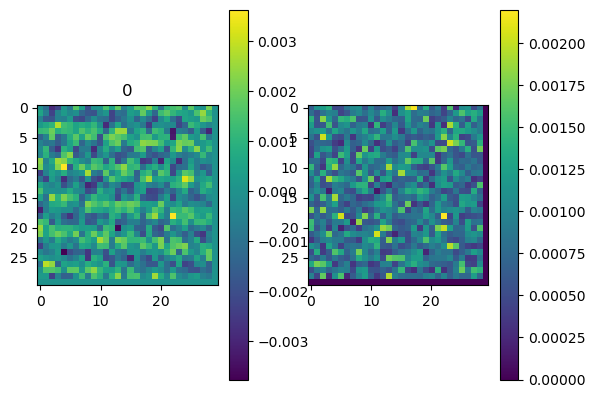

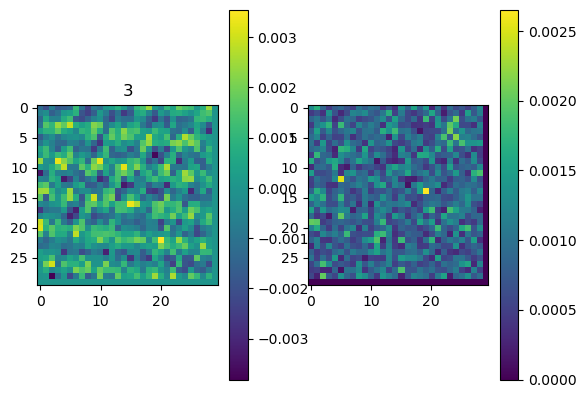

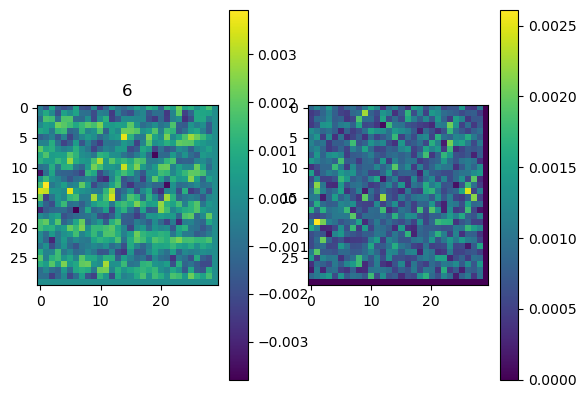

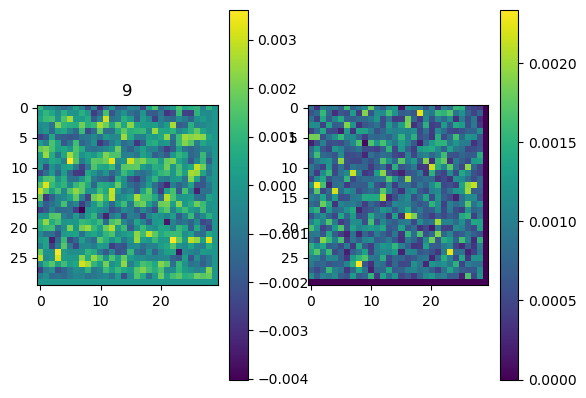

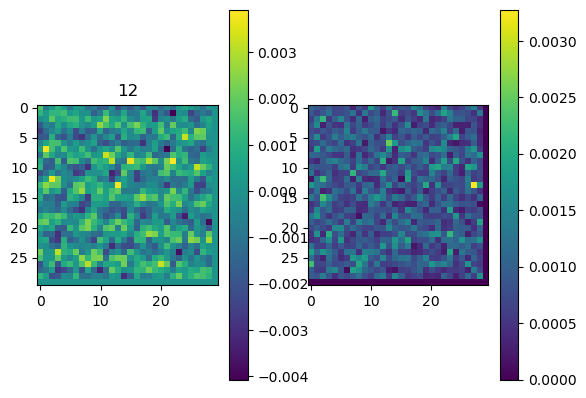

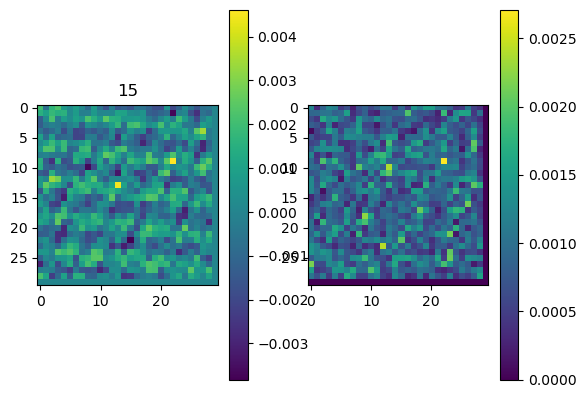

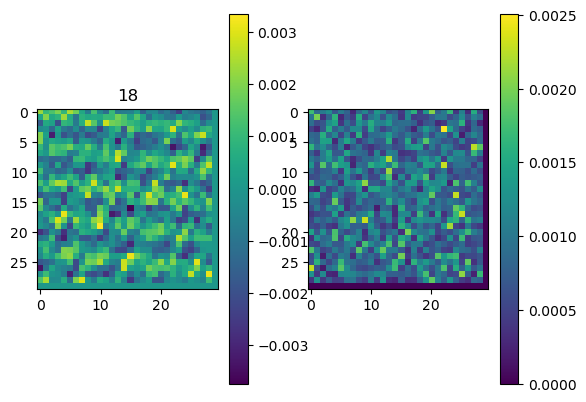

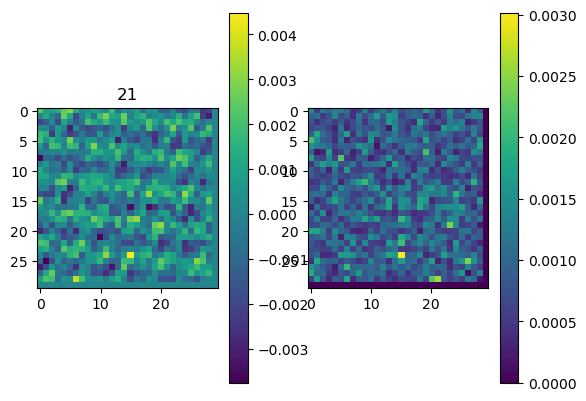

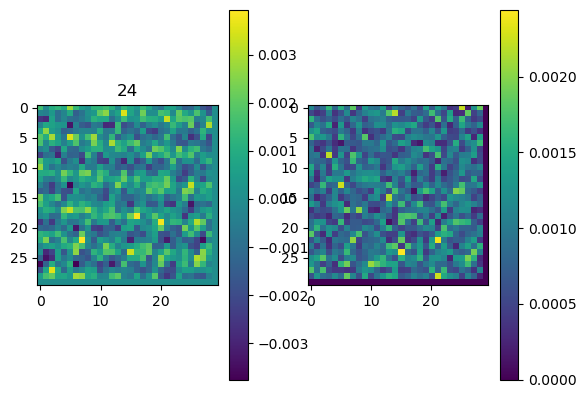

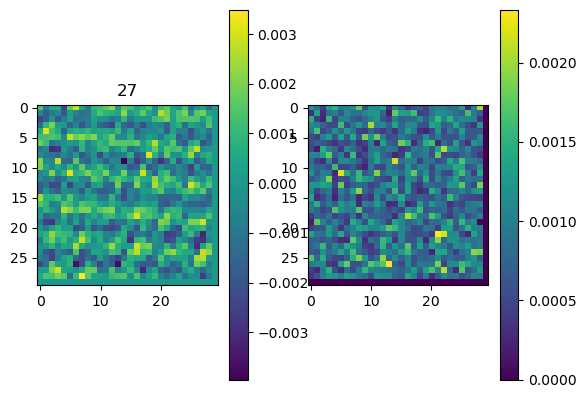

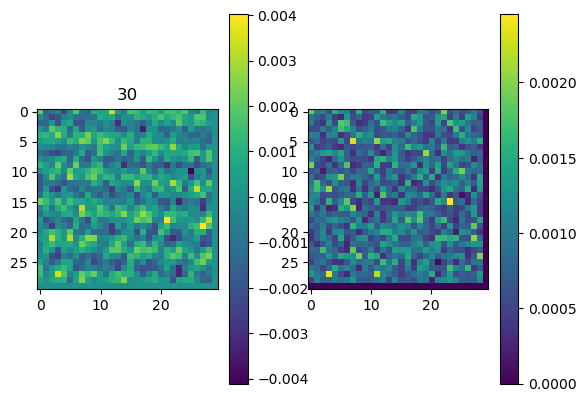

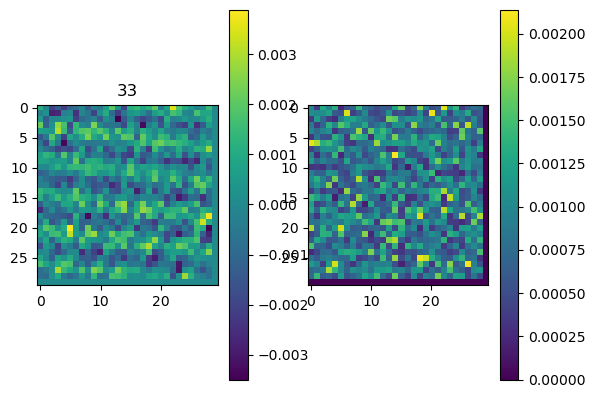

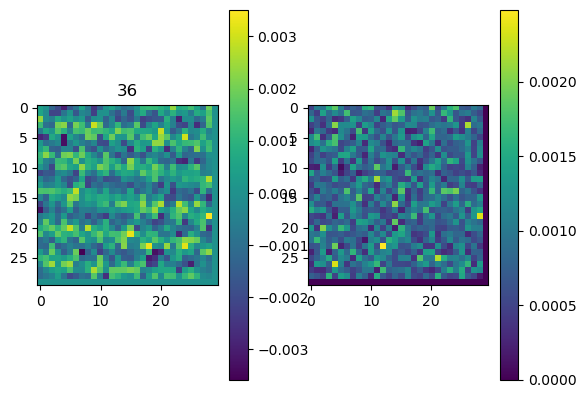

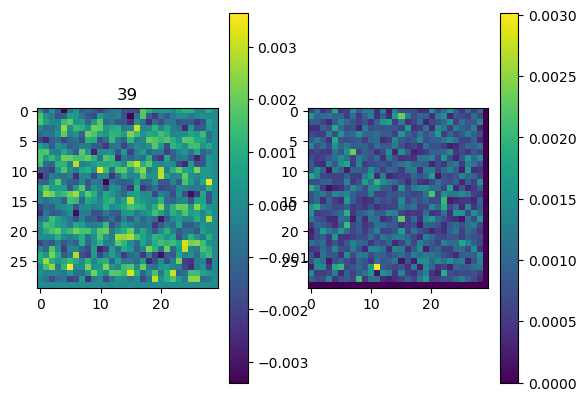

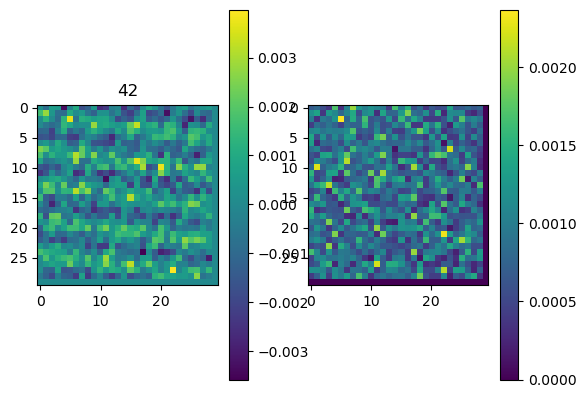

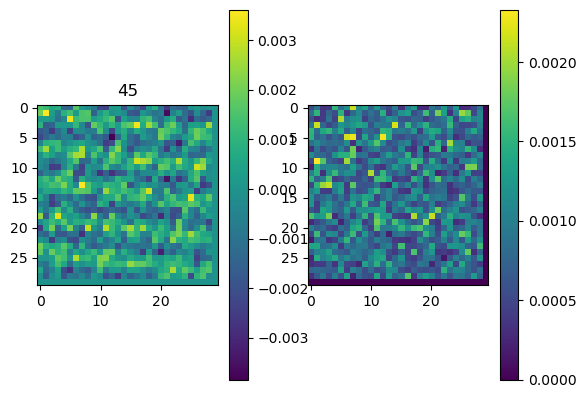

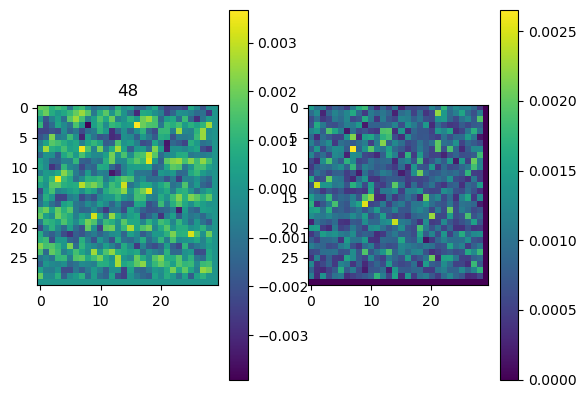

In [13]:
for t_index in range(0,50,3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.title(t_index)
    plt.imshow(sourcemean[t_index,:,:], cmap='viridis') 
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(np.sqrt(sourcevar[t_index,:,:]))#,clim=[-0.15,0.3])
    plt.colorbar()

In [ ]:
exampleparticles = mInfer.genParticlesFromObservations(10)

In [ ]:
exampleparticles[:,0,2]

In [ ]:
plt.plot(exampleparticles[0,:,1],exampleparticles[0,:,2],'x')

In [ ]:
exampleparticles.shape #3430 points going in... each at a given time/space

In [ ]:
trickyparticles = np.random.rand(10,20,18,30,3)

In [ ]:
trickyparticles.shape

In [ ]:
mInfer.windmodel.getwind(trickyparticles).shape #3430 vectors out..

In [ ]:
mInfer.kernel.N_feat

In [ ]:
#Non-negative...
r = 15
nonNegFrom = mInfer.boundary[0]
nonNegTo = mInfer.boundary[1]
Xnonneg = np.array(np.meshgrid(np.linspace(nonNegFrom[0],nonNegTo[0],r+2)[1:-1],np.linspace(nonNegFrom[1],nonNegTo[1],r+2)[1:-1],np.linspace(nonNegFrom[2],nonNegTo[2],r+2)[1:-1]))
Xnonneg = Xnonneg.reshape(3,r**3).T

from advectionGP.constraints import NonNegConstraint
nnc = NonNegConstraint(mInfer,Y,Xnonneg,thinning=30,burnin=30,jitter=1e-6,verbose=True,usecaching=False)
Zs_nonneg = nnc.sample(Nsamps)

sources_nonneg = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs_nonneg])
sourcemean_nonneg = np.mean(sources_nonneg,0)
sourcevar_nonneg = np.var(sources_nonneg,0)

In [ ]:
#nnc = NonNegConstraint(mInfer,Y,Xnonneg,thinning=1000,jitter=0,verbose=False,usecaching=True,burnin=1000)
#nnc.check_convergence(Nchains=4)
#1.25 with GaussianBases.

In [ ]:
scaleby = [10,3,3]
coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]] #20x10x10

concmean,concvar,conc = mInfer.computeConcentration(Zs=Zs,Nsamps=1,Nparticles=10,interpolateSource=True,coords=coords.transpose([1,2,3,0]))
concmean_nonneg,concvar_nonneg,conc_nonneg = mInfer.computeConcentration(Zs=Zs_nonneg,Nsamps=1,Nparticles=10,interpolateSource=True,coords=coords.transpose([1,2,3,0]))

In [ ]:
#to make computing the real concentration quicker, just use a subset of positions
gridps = mInfer.coords.transpose([1,2,3,0]).copy()

gridps = gridps[::scaleby[0],::scaleby[1],::scaleby[2]]
realconc = np.zeros(gridps.shape[:-1])

for i in np.ndindex(gridps.shape[:3]):
    if (i[1]==0) & (i[2]==0): print("%d of %d" % (i[0],gridps.shape[0]))
    _,v= getrealconc(gridps[i][0],gridps[i][1],gridps[i][2],D)
    realconc[i]=v

In [ ]:
plt.plot(sources_nonneg[:,10,15,::5]-np.mean(sources_nonneg[:,10,15,::5],0),'x-')

In [ ]:
np.unique(mInfer.getGridCoord(Xnonneg)[:,0])

In [ ]:
slice_coord=11
gridX = mInfer.getGridCoord(X[:,1:])
plot1d = False
for tsamp in np.array([ 0,  8, 17, 26, 35, 43, 52, 61]):
    plt.figure(figsize=[16,4])
    plt.subplot(1,7,1)
    if tsamp==0: plt.title('source')
    if plot1d:
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sourcemean[tsamp,slice_coord,:])
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sources[:,tsamp,slice_coord,:].T,'k-',alpha=0.5)
        plt.ylim([-.2,0.2])
        plt.grid()
    else:
        plt.imshow(sourcemean[tsamp,:,:])
        plt.colorbar()
        plt.clim([-0.2,0.2])
        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    plt.subplot(1,7,2)
    if tsamp==0: plt.title('std')
    if plot1d:    
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],np.sqrt(sourcevar[tsamp,slice_coord,:]))
        plt.grid()
    else:
        plt.imshow(np.sqrt(sourcevar[tsamp,:,:]))
        plt.clim([0,0.01])
        plt.colorbar()
        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    plt.subplot(1,7,3)
    if tsamp==0: plt.title('conc')
    if plot1d:    
        plt.plot(concmean[tsamp//scaleby[0],slice_coord//scaleby[1],:])
        plt.grid()
    else:
        plt.imshow(concmean[tsamp//scaleby[0],:,:])
        plt.clim([-10,10])
        plt.colorbar()
        plt.scatter(gridX[:,1]/scaleby[1],gridX[:,2]/scaleby[2],1,color='black')
    
    
    plt.subplot(1,7,4)
    if tsamp==0: plt.title('source (non-neg)')
    if plot1d:
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sourcemean_nonneg[tsamp,slice_coord,:])
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],sources_nonneg[:,tsamp,slice_coord,:].T,'k-',alpha=0.5)
        plt.vlines(Xnonneg[:,2],0,-0.01)
        plt.ylim([-.2,0.2])
        plt.grid()
    else:
        plt.imshow(sourcemean_nonneg[tsamp,:,:])    
        plt.colorbar()
        plt.clim([-0.2,0.2])
        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    plt.subplot(1,7,5)
    if tsamp==0: plt.title('std (non-neg)')
    if plot1d:
        plt.plot(mInfer.coords[2,tsamp,slice_coord,:],np.sqrt(sourcevar_nonneg[tsamp,slice_coord,:]))
        plt.grid()
    else:
        plt.imshow(np.sqrt(sourcevar_nonneg[tsamp,:,:]))
        plt.colorbar()
        plt.clim([0,0.01])
        plt.scatter(gridX[:,1],gridX[:,2],1,color='black')

    plt.subplot(1,7,6)
    if tsamp==0: plt.title('conc')
    if plot1d:    
        plt.plot(concmean_nonneg[tsamp//scaleby[0],slice_coord//scaleby[1],:])
        plt.grid()
    else:
        plt.imshow(concmean_nonneg[tsamp//scaleby[0],:,:])
        plt.clim([-10,10])
        plt.colorbar()
        plt.scatter(gridX[:,1]/scaleby[1],gridX[:,2]/scaleby[2],1,color='black')
        
    plt.subplot(1,7,7)
    if tsamp==0: plt.title('realconc')
    if plot1d:    
        plt.plot(realconc[tsamp//scaleby[0],slice_coord//scaleby[1],:])
        plt.grid()
    else:
        plt.imshow(realconc[tsamp//scaleby[0],:,:])   
        plt.clim([-10,10])
        plt.colorbar()

In [ ]:
gridX = mInfer.getGridCoord(X[:,1:])

for tsamp in range(0,mInfer.coords.shape[1],10):
    plt.figure(figsize=[20,4])
    
    plt.subplot(1,7,1)
    if tsamp==0: plt.title('source')
    plt.imshow(sourcemean[tsamp,:,:])
    plt.clim([-0.2,0.2])
    
    plt.subplot(1,7,2)  
    if tsamp==0: plt.title('std')
    plt.imshow(np.sqrt(sourcevar[tsamp,:,:]))
    plt.clim([0,0.05])
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    
    plt.subplot(1,7,3)
    if tsamp==0: plt.title('source(conf)')
    vals = sourcemean[tsamp,:,:]
    alphas = np.sqrt(sourcevar[tsamp,:,:])<0.01
    plt.imshow(vals,alpha=alphas.astype(float))
    plt.clim([-0.2,0.2])    
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    
    plt.subplot(1,7,4)
    if tsamp==0: plt.title('conc')
    plt.imshow(concmean[tsamp//scaleby[0],:,:])
    plt.clim([-5,5])
    #plt.colorbar()
    
    plt.subplot(1,7,5)
    if tsamp==0: plt.title('std')
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    plt.imshow(np.sqrt(concvar[tsamp//scaleby[0],:,:]))
    #plt.clim([0,0.25])
    #plt.colorbar()
    
    plt.subplot(1,7,6)
    if tsamp==0: plt.title('conc(conf)')
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    vals = concmean[tsamp//scaleby[0],:,:]
    alphas = np.sqrt(concvar[tsamp//scaleby[0],:,:])<0.001
    plt.imshow(vals,alpha=alphas.astype(float))
    plt.clim([-10,10])
    #plt.clim([-5,5])
    
    plt.subplot(1,7,7)
    if tsamp==0: plt.title('realconc')
    #plt.scatter(tempgridX[:,1],tempgridX[:,2],1,color='black')
    plt.imshow(realconc[tsamp//scaleby[0],:,:])    
    plt.clim([-10,10])
    ##plt.colorbar()
    
    #t = ts[tsamp*10]
    #plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]*5,color='red')
    #